In [77]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [79]:
data = pd.read_csv("forestfires.csv")
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 48.5+ KB


In [81]:
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [82]:
categorical_columns = [
    c for c in data.columns if data[c].dtype.name == 'object'
]
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['month', 'day']
['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']


In [83]:
for c in categorical_columns:
    print(data[c].unique())

['mar' 'oct' 'aug' 'sep' 'apr' 'jun' 'jul' 'feb' 'jan' 'dec' 'may' 'nov']
['fri' 'tue' 'sat' 'sun' 'mon' 'wed' 'thu']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2100CFD0>,
      dtype=object)

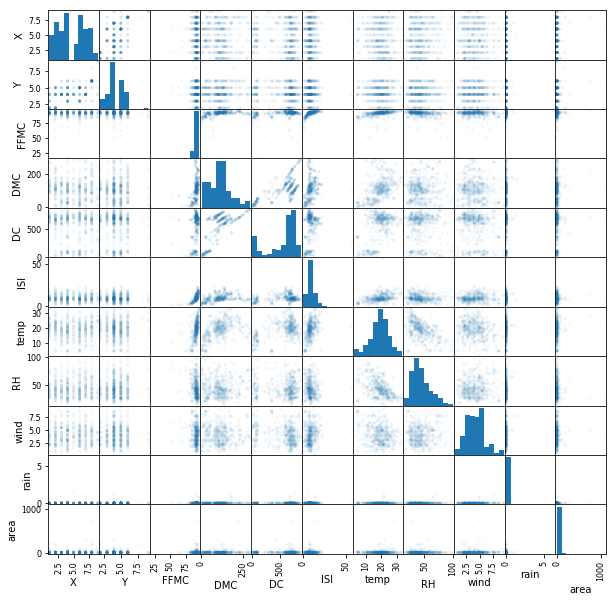

In [84]:
scatter_matrix(data, alpha=0.05, figsize=(10, 10))

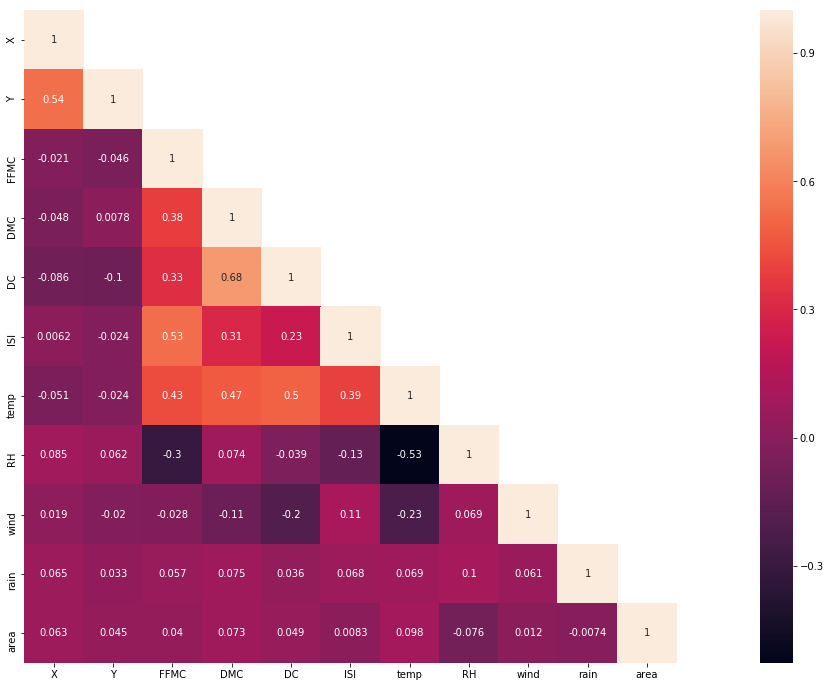

In [85]:
cor_mat = data.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30, 12)
sns.heatmap(data=cor_mat, mask=mask, square=True, annot=True, cbar=True)

In [86]:
data = data.fillna(data.median(axis=0), axis=0)
data.count(axis=0)

X        517
Y        517
month    517
day      517
FFMC     517
DMC      517
DC       517
ISI      517
temp     517
RH       517
wind     517
rain     517
area     517
dtype: int64

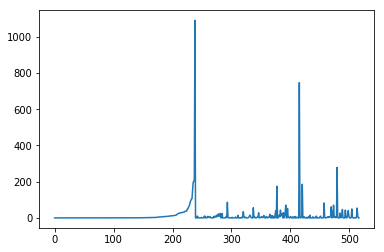

In [87]:
y = data['area']
data.drop(['area'], inplace=True, axis=1)
plt.plot(y)

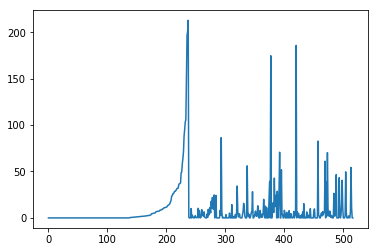

In [88]:
y.loc[y > 250] = y.median()
plt.plot(y)

In [89]:
data_describe = data.describe(include=[object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])
data.describe(include=[object])

,month,day
count,517,517
unique,12,7
top,aug,sun
freq,184,95


In [90]:
binary_columns = [
    c for c in categorical_columns if data_describe[c]['unique'] == 2
]
nonbinary_columns = [
    c for c in categorical_columns if data_describe[c]['unique'] > 2
]
print(binary_columns, nonbinary_columns)

[] ['month', 'day']


In [91]:
for c in binary_columns:
    top = data_describe[c]['top']
    top_items = data[c] == top
    data.loc[top_items, c] = 0
    data.loc[np.logical_not(top_items), c] = 1

In [92]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun',
       'day_thu', 'day_tue', 'day_wed'],
      dtype='object')


In [93]:
numerical_columns.remove('area')
data_numerical = data[numerical_columns]
data_numerical = (
    data_numerical - data_numerical.mean()) / data_numerical.std()
data_numerical.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02,5.170000e+02
mean,1.632049e-16,2.267690e-16,4.202441e-14,-4.672815e-16,1.882870e-15,-7.816657e-16,2.405125e-16,2.061536e-16,-4.191790e-16,-6.871787e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.585825e+00,-1.869913e+00,-1.303319e+01,-1.713948e+00,-2.177000e+00,-1.978662e+00,-2.874160e+00,-1.794899e+00,-2.019142e+00,-7.319742e-02
25%,-7.214373e-01,-2.437649e-01,-8.055651e-02,-6.600260e-01,-4.443977e-01,-5.530598e-01,-5.836726e-01,-6.917863e-01,-7.354113e-01,-7.319742e-02
50%,-2.892437e-01,-2.437649e-01,1.730616e-01,-4.016365e-02,4.686651e-01,-1.363453e-01,7.075224e-02,-1.402302e-01,-9.824197e-03,-7.319742e-02
75%,1.007337e+00,5.693090e-01,4.085641e-01,4.922622e-01,6.690148e-01,3.900308e-01,6.735120e-01,5.338940e-01,4.925053e-01,-7.319742e-02
max,1.871724e+00,3.821605e+00,1.006378e+00,2.817136e+00,1.260389e+00,1.032538e+01,2.481791e+00,3.414243e+00,3.004153e+00,2.155141e+01


In [94]:
data = pd.concat((data_numerical, data[binary_columns], data_nonbinary),
                 axis=1)
data = pd.DataFrame(data, dtype=float)
print(data.shape)
print(data.columns)

(517, 29)
Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun',
       'day_thu', 'day_tue', 'day_wed'],
      dtype='object')


In [95]:
feature_names = data.columns
print(feature_names)

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun',
       'day_thu', 'day_tue', 'day_wed'],
      dtype='object')


In [96]:
print(data.shape)
print(y.shape)
N, d = data.shape

(517, 29)
(517,)


In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.25, random_state=11)

N_train, _ = X_train.shape
N_test, _ = X_test.shape
print(N_train, N_test)
print(y_train.shape, y_test.shape)

387 130
(387,) (130,)


In [98]:
svr = SVR()
svr.fit(X_train, y_train)
sc_test = svr.score(X_test, y_test)
print(sc_test)
scores = cross_val_score(svr, X_test, y_test, cv=10)
print("mean cross validation score: {}".format(np.mean(scores)))

-0.11279716450854305
mean cross validation score: -0.21326284828291103


In [99]:
C_array = np.logspace(-3, 3, num=7)
gamma_array = np.logspace(-5, 2, num=8)
svc = SVC(kernel='rbf')
grid = GridSearchCV(svr, param_grid={'C': C_array, 'gamma': gamma_array})
grid.fit(X_train, y_train)
print('CV error    = ', 1 - grid.best_score_)
print('best C      = ', grid.best_estimator_.C)
print('best gamma  = ', grid.best_estimator_.gamma)

CV error    =  1.0011298871152654
best C      =  1000.0
best gamma  =  100.0


In [100]:
svr = SVR(
    kernel='rbf', C=grid.best_estimator_.C, gamma=grid.best_estimator_.gamma)
svr.fit(X_train, y_train)
sc_test = svr.score(X_test, y_test)
print(sc_test)
scores = cross_val_score(svr, X_test, y_test, cv=10)
print("mean cross validation score: {}".format(np.mean(scores)))

0.007564059598247352
mean cross validation score: -1.8523580069446186


In [101]:
C_array = np.logspace(-3, 3, num=7)
svr = SVR(kernel='linear')
grid = GridSearchCV(svr, param_grid={'C': C_array})
grid.fit(X_train, y_train)
print('CV error    = ', 1 - grid.best_score_)
print('best C      = ', grid.best_estimator_.C)

CV error    =  1.0856454394027273
best C      =  10.0


In [102]:
svr = SVR(kernel='linear', C=grid.best_estimator_.C)
svr.fit(X_train, y_train)
sc_test = svr.score(X_test, y_test)
print(sc_test)
scores = cross_val_score(svr, X_test, y_test, cv=10)
print("mean cross validation score: {}".format(np.mean(scores)))

-0.10076303074226667
mean cross validation score: -0.1902354753658123


In [ ]:
C_array = np.logspace(-5, 2, num=8)
gamma_array = np.logspace(-5, 2, num=8)
degree_array = [2, 3, 4]
svr = SVR(kernel='poly')
grid = GridSearchCV(
    svr,
    param_grid={
        'C': C_array,
        'gamma': gamma_array,
        'degree': degree_array
    })
grid.fit(X_train, y_train)
print('CV error    = ', 1 - grid.best_score_)
print('best C      = ', grid.best_estimator_.C)
print('best gamma  = ', grid.best_estimator_.gamma)
print('best degree = ', grid.best_estimator_.degree)

In [ ]:
svr = SVR(
    kernel='poly',
    C=grid.best_estimator_.C,
    gamma=grid.best_estimator_.gamma,
    degree=grid.best_estimator_.degree)
svr.fit(X_train, y_train)
sc_test = svr.score(X_test, y_test)
print(sc_test)
scores = cross_val_score(svr, X_test, y_test, cv=10)
print("mean cross validation score: {}".format(np.mean(scores)))